In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import argparse
import torch
import torchvision
import torch.nn.functional as F
import numpy as np

from nn.enums import ExplainingMethod
from nn.networks import ExplainableNet
from nn.utils import get_expl, plot_overview, clamp, load_image, make_dir
import keras
from keras import datasets 
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline


no display found. Using non-interactive Agg backend


Using TensorFlow backend.
/home/raj_vardhan/anaconda3/envs/torch_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/raj_vardhan/anaconda3/envs/torch_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/raj_vardhan/anaconda3/envs/torch_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

In [2]:
def get_beta(i, num_iter):
    """
    Helper method for beta growth
    """
    start_beta, end_beta = 10.0, 100.0
    return start_beta * (end_beta / start_beta) ** (i / num_iter)

# def np_img_to_tensor(grayscale_img):
#     rgb_img = np.repeat(grayscale_img[..., np.newaxis], 3, -1)
#     im = Image.fromarray(rgb_img)
#     x = torchvision.transforms.Normalize(mean=data_mean, std=data_std)(torchvision.transforms.ToTensor()(torchvision.transforms.Resize(224)(im)))
#     x = x.unsqueeze(0).to(device)
#     return x

def np_img_to_tensor(input_img,data_mean,data_std, device, num_ch=1):
    if num_ch == 1:
        rgb_img = np.repeat(input_img[..., np.newaxis], 3, -1)
    else:
        rgb_img = input_img
    im = Image.fromarray(rgb_img)
    x = torchvision.transforms.Normalize(mean=data_mean, std=data_std)(torchvision.transforms.ToTensor()(torchvision.transforms.Resize(224)(im)))
    x = x.unsqueeze(0).to(device)
    return x

In [3]:
# args
args_cuda = True
args_method = 'lrp'
args_beta_growth = None
args_num_iter = 500
args_prefactors = [1e11, 1e6]
args_lr = 2* (10**(-3))
args_output_dir = '../output/'
args_role = 'adversary'
args_dataset = 'fmnist'
target_class_idx = 6
attack_method = 'cwl2/conf_0'
args_adv_dir = '../../xai-adv/data/postndss/{}/{}/target_next/target_{}/{}/'
num_ch = 1

In [4]:
# options
device = torch.device("cuda" if args_cuda else "cpu")
method = getattr(ExplainingMethod, args_method)
print('Explanation method {} will be used'.format(method))

# load model
data_mean = np.array([0.0, 0.0, 0.0])
data_std = np.array([1.0, 1.0, 1.0])

vgg_model = torchvision.models.vgg16(pretrained=True)
model = ExplainableNet(vgg_model, data_mean=data_mean, data_std=data_std, beta=1000 if args_beta_growth else None)
if method == ExplainingMethod.pattern_attribution:
    model.load_state_dict(torch.load('../models/model_vgg16_pattern_small.pth'), strict=False)
model = model.eval().to(device)

print(vgg_model)

Explanation method ExplainingMethod.lrp will be used
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Max

In [5]:
adv_dir = args_adv_dir.format(args_role, args_dataset, str(target_class_idx), attack_method)
x_train = np.load(adv_dir + '/x_adv_ar.npy')
print('Loading {} adv samples from {} '.format(x_train.shape[0],adv_dir))
x_train = x_train[0:10]
print('Retaining {} adv samples'.format(x_train.shape[0]))
x_train = (x_train*255).astype(np.uint8)

Loading 100 adv samples from ../../xai-adv/data/postndss/adversary/fmnist/target_next/target_6/cwl2/conf_0/ 
Retaining 10 adv samples


In [6]:
# The sample is initialized with adversarial example. We will derive adv2 from this 
sample = x_train[0]
print(sample.shape)
print(np.min(sample), np.max(sample))

(28, 28)
0 254


In [13]:
x = np_img_to_tensor(sample, data_mean, data_std, device, num_ch=1)
x_adv = x.clone().detach().requires_grad_()
print(x.shape)
print(torch.min(x), torch.max(x),torch.mean(x))

torch.Size([1, 3, 224, 224])
tensor(0., device='cuda:0') tensor(0.9843, device='cuda:0')


In [14]:
x_pred = model(x)
x_pred_class = torch.argmax(x_pred,axis=1)
print('original class of x is ',int(x_pred_class))

original class of x is  111


In [15]:
org_expl, org_acc, org_idx = get_expl(model, x, method)
org_expl = org_expl.detach().cpu()

# The class from which we will derive the target explanation
target_class_idx = 6
# pick index of x_train where the label is that of the source class
(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = datasets.fashion_mnist.load_data()
idx = np.where(y_train_orig == target_class_idx)[0][0]
grayscale_img_src = x_train_orig[idx]
x_target = np_img_to_tensor(grayscale_img_src,data_mean,data_std, device, num_ch)
target_expl, _, _ = get_expl(model, x_target, method)
target_expl = target_expl.detach()

This is the adversarial example


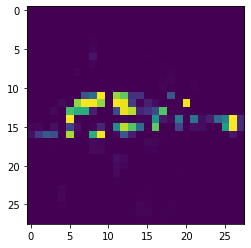

In [27]:
print('This is the adversarial example')
plt.imshow(sample)

This is an image from the target class which we will use to produce the target explanation


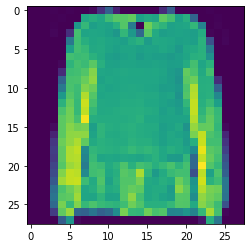

In [17]:
print('This is an image from the target class which we will use to produce the target explanation')
plt.imshow(x_train_orig[idx])

This is the current explanation of the adversarial example


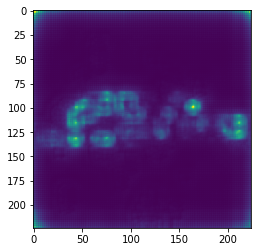

In [18]:
print('This is the current explanation of the adversarial example')
org_expl_np = org_expl.cpu().numpy()
plt.imshow(org_expl_np[0])

This is the target explanation we want


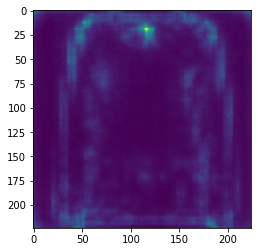

In [19]:
print('This is the target explanation we want')
target_expl_np = target_expl.cpu().numpy()
plt.imshow(target_expl_np[0])

### Now we do the attack and produce adv2 which results in the target explanation map

In [20]:
optimizer = torch.optim.Adam([x_adv], lr=args_lr)

for i in range(args_num_iter):
    if args_beta_growth:
        model.change_beta(get_beta(i, args_num_iter))

    optimizer.zero_grad()

    # calculate loss
    adv_expl, adv_acc, class_idx = get_expl(model, x_adv, method, desired_index=org_idx)
    loss_expl = F.mse_loss(adv_expl, target_expl)
    loss_output = F.mse_loss(adv_acc, org_acc.detach())
    total_loss = args_prefactors[0]*loss_expl + args_prefactors[1]*loss_output

    # update adversarial example
    total_loss.backward()
    optimizer.step()

    # clamp adversarial example
    # Note: x_adv.data returns tensor which shares data with x_adv but requires
    #       no gradient. Since we do not want to differentiate the clamping,
    #       this is what we need
    x_adv.data = clamp(x_adv.data, data_mean, data_std)

    print("Iteration {}: Total Loss: {}, Expl Loss: {}, Output Loss: {}".format(i, total_loss.item(), loss_expl.item(), loss_output.item()))

Iteration 0: Total Loss: 112.41120147705078, Expl Loss: 1.1241120256855197e-09, Output Loss: 0.0
Iteration 1: Total Loss: 102.52704620361328, Expl Loss: 1.0216294477061183e-09, Output Loss: 3.6410398251973675e-07
Iteration 2: Total Loss: 94.26116943359375, Expl Loss: 9.340127560264477e-10, Output Loss: 8.598939871262701e-07
Iteration 3: Total Loss: 87.03701782226562, Expl Loss: 8.56572035523584e-10, Output Loss: 1.379815785185201e-06
Iteration 4: Total Loss: 80.15913391113281, Expl Loss: 7.834561888131475e-10, Output Loss: 1.8135134496333194e-06
Iteration 5: Total Loss: 74.03313446044922, Expl Loss: 7.185745332094484e-10, Output Loss: 2.175685494876234e-06
Iteration 6: Total Loss: 68.5711441040039, Expl Loss: 6.622170589665188e-10, Output Loss: 2.3494449123973027e-06
Iteration 7: Total Loss: 64.00694274902344, Expl Loss: 6.162501064999049e-10, Output Loss: 2.381938884354895e-06
Iteration 8: Total Loss: 59.53727340698242, Expl Loss: 5.720241502693568e-10, Output Loss: 2.334857754249242e

Iteration 74: Total Loss: 2.6005358695983887, Expl Loss: 2.377062956193665e-11, Output Loss: 2.234729663541657e-07
Iteration 75: Total Loss: 2.564150094985962, Expl Loss: 2.3401702450853712e-11, Output Loss: 2.2397985333100223e-07
Iteration 76: Total Loss: 2.528193235397339, Expl Loss: 2.29929998651901e-11, Output Loss: 2.2889338424647576e-07
Iteration 77: Total Loss: 2.501558542251587, Expl Loss: 2.264152754172244e-11, Output Loss: 2.3740584254028363e-07
Iteration 78: Total Loss: 2.449890613555908, Expl Loss: 2.235156677798944e-11, Output Loss: 2.1473400124705222e-07
Iteration 79: Total Loss: 2.3927526473999023, Expl Loss: 2.1843572090007868e-11, Output Loss: 2.0839559056184953e-07
Iteration 80: Total Loss: 2.3536629676818848, Expl Loss: 2.1567161251345723e-11, Output Loss: 1.9694684283422248e-07
Iteration 81: Total Loss: 2.3051040172576904, Expl Loss: 2.11198558641712e-11, Output Loss: 1.9311860910420364e-07
Iteration 82: Total Loss: 2.2555294036865234, Expl Loss: 2.0675322565111287e

Iteration 146: Total Loss: 1.2082642316818237, Expl Loss: 1.1162932557484684e-11, Output Loss: 9.197106010105927e-08
Iteration 147: Total Loss: 1.200128197669983, Expl Loss: 1.1082790067618031e-11, Output Loss: 9.184917360016698e-08
Iteration 148: Total Loss: 1.1937400102615356, Expl Loss: 1.1023106039065311e-11, Output Loss: 9.142950574414499e-08
Iteration 149: Total Loss: 1.1854630708694458, Expl Loss: 1.0947871081912197e-11, Output Loss: 9.067598938372612e-08
Iteration 150: Total Loss: 1.1777136325836182, Expl Loss: 1.0884251833154224e-11, Output Loss: 8.92884415293338e-08
Iteration 151: Total Loss: 1.1733644008636475, Expl Loss: 1.083038173033124e-11, Output Loss: 9.032633130345857e-08
Iteration 152: Total Loss: 1.166463851928711, Expl Loss: 1.0767576934245238e-11, Output Loss: 8.970617670911452e-08
Iteration 153: Total Loss: 1.1587252616882324, Expl Loss: 1.0700805692931414e-11, Output Loss: 8.864476797043608e-08
Iteration 154: Total Loss: 1.1495001316070557, Expl Loss: 1.06330309

Iteration 218: Total Loss: 0.8457195162773132, Expl Loss: 7.882971185535492e-12, Output Loss: 5.742237974004638e-08
Iteration 219: Total Loss: 0.8393208980560303, Expl Loss: 7.828346478000459e-12, Output Loss: 5.6486246791109807e-08
Iteration 220: Total Loss: 0.836342453956604, Expl Loss: 7.80480801515493e-12, Output Loss: 5.586163709381253e-08
Iteration 221: Total Loss: 0.8336138129234314, Expl Loss: 7.782963509783691e-12, Output Loss: 5.5317478597771697e-08
Iteration 222: Total Loss: 0.8304793834686279, Expl Loss: 7.747099836641347e-12, Output Loss: 5.576947259555709e-08
Iteration 223: Total Loss: 0.8262818455696106, Expl Loss: 7.703882670684337e-12, Output Loss: 5.589357243707127e-08
Iteration 224: Total Loss: 0.8210780620574951, Expl Loss: 7.661764452049358e-12, Output Loss: 5.490166543609121e-08
Iteration 225: Total Loss: 0.8182742595672607, Expl Loss: 7.64101108774451e-12, Output Loss: 5.417317083811213e-08
Iteration 226: Total Loss: 0.8175152540206909, Expl Loss: 7.6269606949508

Iteration 290: Total Loss: 0.6538339853286743, Expl Loss: 6.127416716378287e-12, Output Loss: 4.109235973714931e-08
Iteration 291: Total Loss: 0.6479710936546326, Expl Loss: 6.0855465632003725e-12, Output Loss: 3.9416452324303464e-08
Iteration 292: Total Loss: 0.6441856622695923, Expl Loss: 6.043854652859615e-12, Output Loss: 3.980023066674221e-08
Iteration 293: Total Loss: 0.6452441215515137, Expl Loss: 6.058833122712937e-12, Output Loss: 3.936083814437552e-08
Iteration 294: Total Loss: 0.6429007053375244, Expl Loss: 6.022604723959768e-12, Output Loss: 4.064020586724837e-08
Iteration 295: Total Loss: 0.6445410847663879, Expl Loss: 6.012880297834311e-12, Output Loss: 4.325306335317691e-08
Iteration 296: Total Loss: 0.6444925665855408, Expl Loss: 6.0285491876310715e-12, Output Loss: 4.163766220699472e-08
Iteration 297: Total Loss: 0.6440740823745728, Expl Loss: 6.020709972243132e-12, Output Loss: 4.200312275770557e-08
Iteration 298: Total Loss: 0.6422240138053894, Expl Loss: 6.017003301

Iteration 362: Total Loss: 0.5402683019638062, Expl Loss: 5.11032882677398e-12, Output Loss: 2.9235440734964868e-08
Iteration 363: Total Loss: 0.5414208769798279, Expl Loss: 5.110631969701407e-12, Output Loss: 3.035773588067059e-08
Iteration 364: Total Loss: 0.5400123596191406, Expl Loss: 5.093872806199995e-12, Output Loss: 3.062512377027815e-08
Iteration 365: Total Loss: 0.5400227308273315, Expl Loss: 5.100168551375184e-12, Output Loss: 3.000585735435379e-08
Iteration 366: Total Loss: 0.5353488326072693, Expl Loss: 5.051838721653601e-12, Output Loss: 3.0164962083745195e-08
Iteration 367: Total Loss: 0.531274139881134, Expl Loss: 5.02260516163644e-12, Output Loss: 2.9013628832785798e-08
Iteration 368: Total Loss: 0.5283098816871643, Expl Loss: 4.999679923539668e-12, Output Loss: 2.834191015210763e-08
Iteration 369: Total Loss: 0.5256828665733337, Expl Loss: 4.972761352001198e-12, Output Loss: 2.8406732965891024e-08
Iteration 370: Total Loss: 0.524903416633606, Expl Loss: 4.961203323161

Iteration 434: Total Loss: 0.44397130608558655, Expl Loss: 4.202000726538646e-12, Output Loss: 2.377124630470462e-08
Iteration 435: Total Loss: 0.4425671100616455, Expl Loss: 4.187953369511055e-12, Output Loss: 2.3771793422611154e-08
Iteration 436: Total Loss: 0.4408455491065979, Expl Loss: 4.1734723316144695e-12, Output Loss: 2.3498323287185485e-08
Iteration 437: Total Loss: 0.43892931938171387, Expl Loss: 4.156552272510661e-12, Output Loss: 2.327409553970483e-08
Iteration 438: Total Loss: 0.43724796175956726, Expl Loss: 4.140895525778232e-12, Output Loss: 2.315843516953464e-08
Iteration 439: Total Loss: 0.43598055839538574, Expl Loss: 4.128403782027723e-12, Output Loss: 2.314019909022136e-08
Iteration 440: Total Loss: 0.43558481335639954, Expl Loss: 4.12696049209571e-12, Output Loss: 2.2888769990458968e-08
Iteration 441: Total Loss: 0.4341069757938385, Expl Loss: 4.110217374786451e-12, Output Loss: 2.3085240385967154e-08
Iteration 442: Total Loss: 0.4322884678840637, Expl Loss: 4.093

In [21]:
# Test with original model (with relu activations)
model.change_beta(None)

# find the predicted class of x_adv2
x_adv_pred = model(x_adv)
print('predicted class of x_adv_2 is ',torch.argmax(x_adv_pred,axis=1))

adv_expl, _, _ = get_expl(model, x_adv, method)

# save results
# output_dir = make_dir(args_output_dir)
# plot_overview([x_target, x, x_adv], [target_expl, org_expl, adv_expl], data_mean, data_std, filename=f"{output_dir}overview_{args_method}.png")
# torch.save(x_adv, f"{output_dir}x_{args_method}.pth")

predicted class of x_adv_2 is  tensor([111], device='cuda:0')


In [37]:
print(type(x_adv))
print(torch.min(x_adv), torch.max(x_adv))
print(torch.mean(x_adv))

<class 'torch.Tensor'>
tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0549, device='cuda:0', grad_fn=<MeanBackward0>)


In [47]:
torch.save(x_adv, "../data/x_adv.pt")

In [48]:
x_adv_loaded = torch.load("../data/x_adv.pt")

In [49]:
adv_expl, _, _ = get_expl(model, x_adv_loaded, method)


# Retrieve the resulting adversarial example

In [38]:
side = 28
x_adv2_big = x_adv.detach().cpu().numpy()

im2 = Image.fromarray(x_adv2_big[0][0])
x_adv2_small = torchvision.transforms.ToTensor()(torchvision.transforms.Resize(side)(im2))
x_adv2_small_np = x_adv2_small.numpy()
x_adv2_small_np = x_adv2_small_np.reshape(side, side)
#x_adv2_small_np = (x_adv2_small_np *255).astype(np.uint8)

In [41]:
print(np.min(x_adv2_big), np.max(x_adv2_big))

0.0 1.0


In [40]:
print(np.min(x_adv2_small_np), np.max(x_adv2_small_np))

0.0044801235 0.80561244


In [36]:
print(np.min(x_adv2_small_np), np.max(x_adv2_small_np))

1 205


This is the adv_2 adversarial example which produces the target map by the target explanation method


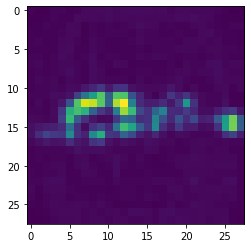

In [23]:
print('This is the adv_2 adversarial example which produces the target map by the target explanation method')
plt.imshow(x_adv2_small_np)

0 254
1 205


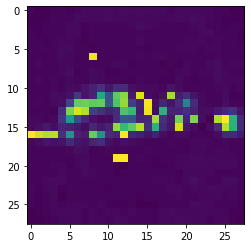

In [26]:
print(np.min(sample), np.max(sample))
print(np.min(x_adv2_small_np), np.max(x_adv2_small_np))

# changes between adv and adv2
pert = abs(x_adv2_small_np - sample)
plt.imshow(pert)

torch.Size([1, 224, 224])
(28, 28)


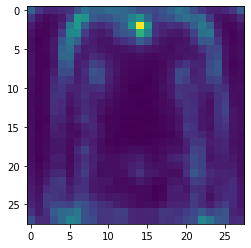

In [50]:
print(adv_expl.shape)
adv_expl = adv_expl.detach().cpu()
adv_expl_np = adv_expl.numpy()
adv_expl_np = adv_expl_np.reshape(224, 224)
im2 = Image.fromarray(adv_expl_np)
adv_expl2 = torchvision.transforms.ToTensor()(torchvision.transforms.Resize(side)(im2))
adv_expl_np2 = adv_expl2.numpy()
adv_expl_np2 = adv_expl_np2.reshape(side, side)
print(adv_expl_np2.shape)
plt.imshow(adv_expl_np2)

In [28]:
# role = 'adversary'
# dataset = 'fmnist'
# output_dir = '../data/'
# attack_method = 'cwl2/conf_0'
# exp_method = 'lrp'
# adv_src_class_idx = 5
# output_dir = output_dir + '/' + role + '/' + dataset + '/' + 'adv2/' + attack_method + '/' + exp_method + '/from_' + str(adv_src_class_idx) + '/'

# if not os.path.exists(output_dir):
#     print('creating directory ',output_dir)
#     os.makedirs(output_dir)

# print('storing results in ',output_dir)
# #np.save(output_dir+'x_adv2.npy', x_adv2_small_np)


creating directory  ../data//adversary/fmnist/adv2/cwl2/conf_0/lrp/from_5/
storing results in  ../data//adversary/fmnist/adv2/cwl2/conf_0/lrp/from_5/


# Now use the adv2 example and produce its explanation

In [42]:
print(type(x_adv2_small_np))
print(x_adv2_small_np.shape)
print(np.min(x_adv2_small_np), np.max(x_adv2_small_np))

<class 'numpy.ndarray'>
(28, 28)
0.0044801235 0.80561244


In [35]:
x2 = np_img_to_tensor(x_adv2_small_np, data_mean, data_std, device, num_ch=1)
print(type(x2))
print(torch.min(x2), torch.max(x2))
print(torch.mean(x2))

<class 'torch.Tensor'>
tensor(0.0039, device='cuda:0') tensor(0.7922, device='cuda:0')
tensor(0.0525, device='cuda:0')


torch.Size([1, 3, 224, 224])
original class of x [adv2 example] is  111
This is the explanation of the adv2 example


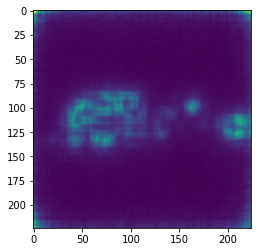

In [44]:

x_adv2 = x2.clone().detach().requires_grad_()
print(x2.shape)

x_pred = model(x2)
x_pred_class = torch.argmax(x_pred,axis=1)
print('original class of x [adv2 example] is ',int(x_pred_class))

org_expl2, _,_ = get_expl(model, x2, method)
org_expl2 = org_expl2.detach().cpu()

print('This is the explanation of the adv2 example')
org_expl_np2 = org_expl2.cpu().numpy()
plt.imshow(org_expl_np2[0])
